In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src/Hierarchical-Localization/')

In [3]:
from scipy.io import loadmat
import numpy as np
import cv2

from hloc.localize_inloc import get_scan_pose
import pycolmap

import os
from pathlib import Path
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [110]:
def get_pose(dataset_dir, path_to_mat, K):
    '''
    :param dataset_dir: path to InLoc files
    :param path_to_mat: path to .mat file, which contains pointcloud, H x W x 3
    :param K: calibration matrix, 3 x 3
    '''
    pc = loadmat(path_to_mat)['XYZcut']
    Tr = get_scan_pose(dataset_dir, path_to_mat) #transform to global coordinate frame
    w, h = np.meshgrid(np.arange(1600), np.arange(1200), indexing='xy')
    points2d_ = np.concatenate((w[..., None], h[..., None]), axis=-1).reshape(-1, 2) #by row
    points3d_ = pc.reshape(-1, 3)
    
    mask = ~np.isnan(points3d_).all(1)

    points3d_ = points3d_[mask]
    points2d_ = points2d_[mask]
    
    points3d_ = (Tr[:3, :3] @  points3d_.T + Tr[:3, -1:]).T
    points3d = np.ascontiguousarray(points3d_).astype('float64')
    points2d = np.ascontiguousarray(points2d_).reshape((-1,1,2)).astype('float64')
   
    _, r, t = cv2.solvePnP(points3d, points2d, K, None, cv2.SOLVEPNP_ITERATIVE)
    R, _ = cv2.Rodrigues(r)
    
    T_w2c = np.zeros((4, 4), dtype='float64')
    T_w2c[:3, :3] = R
    T_w2c[:3, 3] = t.ravel()
    T_w2c[3, 3] = 1.
    T_c2w = np.linalg.inv(T_w2c)
    
    return T_c2w    

In [112]:
poses = []

path = Path('/home/project/data/InLoc/database/poses/')
for directory, subdirectory, files in os.walk(path):
    for file in files:
        t = np.loadtxt(os.path.join(directory, file))[:3, 3]
        poses.append(t)

In [113]:
pathes = []
for directory, subdirectory, files in os.walk('/home/project/data/InLoc/database/cutouts/'):
    for name in files:
        if name.endswith('mat'):
            pathes.append(Path(directory) / name)

In [ ]:
K = np.array([[3136., 0., 800.],
              [0, 3136., 600.], 
              [0., 0., 1.]])

for path in tqdm(pathes):
    split_image_path = str(path).split('/')
    floor_name = split_image_path[-3]
    scan_id = split_image_path[-2]
    image_name = split_image_path[-1].split('.')[0]
    building_name = image_name[:3]
    
    dir_name = Path('/home/project/data/InLoc/database/poses') / floor_name / scan_id
    dir_name.mkdir(parents=True, exist_ok=True)
    pose = get_pose('/home/project/data/InLoc/', str(path), K)    
    np.savetxt(dir_name / (image_name + ".txt"), pose)


 78%|█████████████████████████████████████████████████████████████████████████████████████▎                        | 3631/4680 [10:33:15<2:57:55, 10.18s/it]

In [78]:
poses_duc1 = []
poses_duc2 = []
pathes_duc1 = []
pathes_duc2 = []

for directory, subdirectory, files in os.walk('/home/project/data/InLoc/database/poses'):
    for file in files:
        if file.endswith('.txt'):
            if 'DUC1' in directory:
                pathes_duc1.append(os.path.join(directory, file))
                poses_duc1.append(np.loadtxt(pathes_duc1[-1]))
                
            else:
                pathes_duc2.append(os.path.join(directory, file))
                poses_duc2.append(np.loadtxt(pathes_duc2[-1]))
                
poses_duc1 = np.array(poses_duc1)
poses_duc2 = np.array(poses_duc2)

In [79]:
keep_duc1 = (np.abs(poses_duc1[:, :3, 3]) < 100).all(1)
keep_duc2 = (np.abs(poses_duc2[:, :3, 3]) < 100).all(1)

t_duc1 = poses_duc1[keep_duc1, :3, 3]
t_duc2 = poses_duc2[keep_duc2, :3, 3]

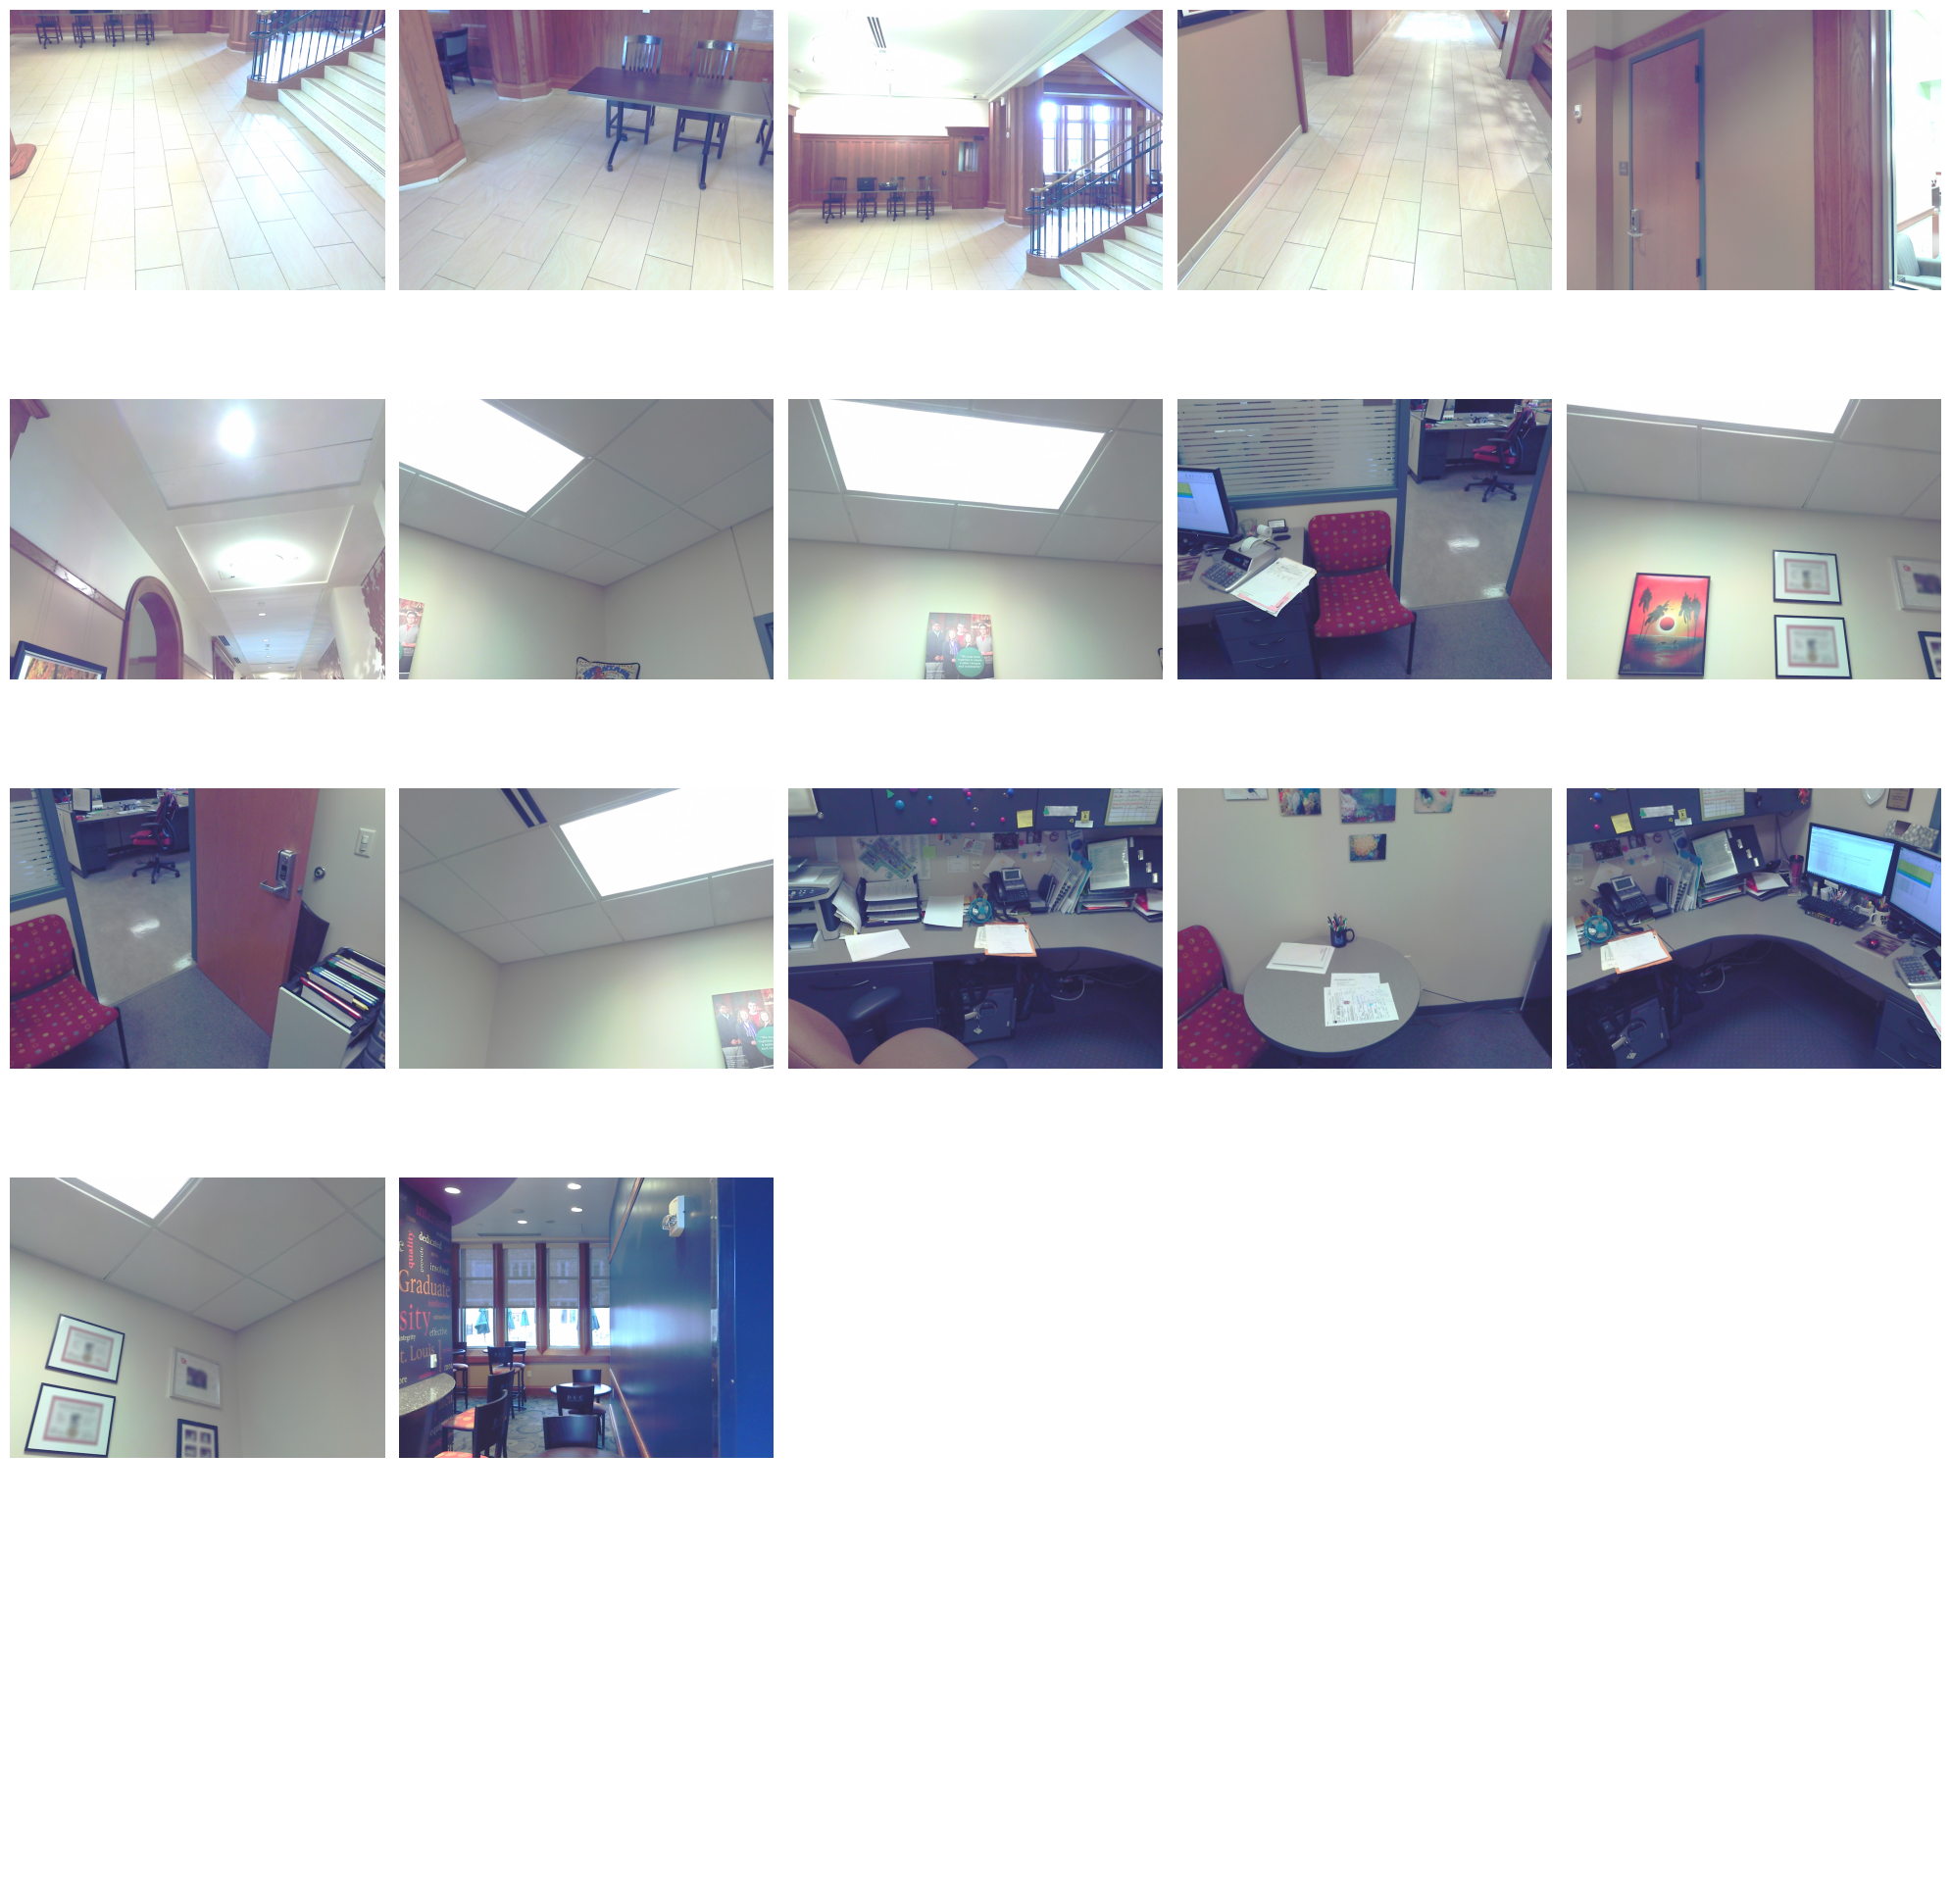

In [118]:
ps = [pathes_duc1[i].replace('poses', 'cutouts').replace('txt', 'jpg') for i, t in enumerate(t_duc1) if (t[1] < 5) and (t[1] > -5) and (t[0] > -25) and (t[0] < -20)] 

m = 5
n = len(ps) // m +  len(ps) % m


fig, ax = plt.subplots(n, m, figsize=(20, 20))

for p, a in zip(ps, ax.flatten()):
    a.imshow(plt.imread(p))
    
for a in ax.flatten():
    a.set_axis_off()
    
plt.tight_layout()


0.8346281908990011
0.8701388888888889


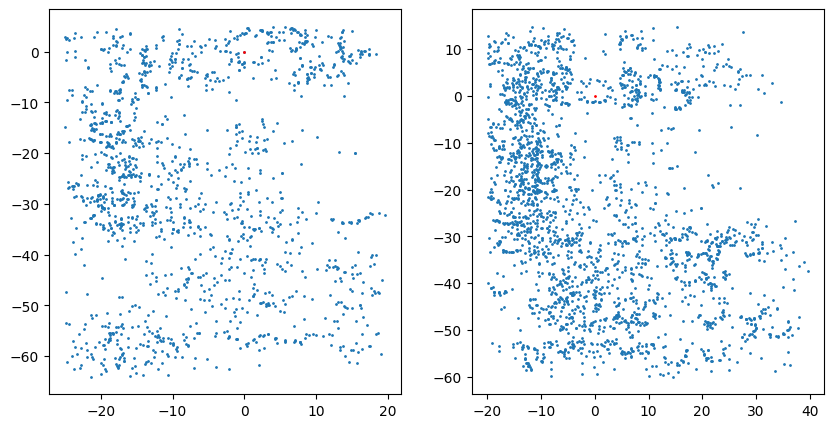

In [129]:
keep_duc1 = (poses_duc1[:, 1, 3] < 5) & (poses_duc1[:, 1, 3] > -65) & (poses_duc1[:, 0, 3] > -25) & (poses_duc1[:, 0, 3] < 20) 
print(keep_duc1.mean())
keep_duc2 = (poses_duc2[:, 1, 3] < 15) & (poses_duc2[:, 1, 3] > -60) & (poses_duc2[:, 0, 3] > -20) & (poses_duc2[:, 0, 3] < 40) 
print(keep_duc2.mean())
t_duc1 = poses_duc1[keep_duc1, :3, 3]
t_duc2 = poses_duc2[keep_duc2, :3, 3]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(t_duc1[:, 0], t_duc1[:, 1], s=1)
ax[0].scatter(0, 0, c='r', s=1)
ax[1].scatter(t_duc2[:, 0], t_duc2[:, 1], s=1)
ax[1].scatter(0, 0, c='r', s=1)
